![](https://archive.ics.uci.edu/ml/assets/logo.gif)

## We are going to analyze below dataset from UCI: 
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#
## Our aim is to build a model to predict Energy Consumption.

## Information about the dataset:
The dataset contains observations of a 5 month period: **11 January 2016 to 27 May 2016.** The dataset is a combination of measurements of humidity and temperature from households and weather data.
All the variables are continuous except for the variables of Consumption (Appliances and Lights).


**The data set is at 10 min observations.** The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. 


Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from IPython.display import Image
import math

In [2]:
energy = pd.read_csv('energydata_complete.csv')
energy['date'] = pd.to_datetime(energy['date'],format = '%Y%m%d %H:%M:%S')

In [3]:
# Extract date and hour into seperate columns
new_date = [d.date() for d in energy['date']]
new_hour = [d.time() for d in energy['date']]
energy.insert(loc = 2, column = 'Date', value=new_date)
energy.insert(loc = 3, column = 'Hour', value=new_hour)

In [4]:
energy['Date'] = pd.to_datetime(energy['Date'], format = '%Y-%m-%d')
energy['Hour'] = pd.to_datetime(energy['Hour'], format = '%H:%M:%S')

In [5]:
energy.columns

Index(['date', 'Appliances', 'Date', 'Hour', 'lights', 'T1', 'RH_1', 'T2',
       'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7',
       'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

## We are going to find the sunrise and sunset information for the city of Chievres.
We use **BeautifulSoup** to scrap from this website: https://www.sunrise-and-sunset.com/en

In [6]:
url = 'https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/'
valid_pages =  ['january','february','march','april','may']

In [7]:
url_new = []
for n in range(len(valid_pages)):
    url_new.append(f'{url}{valid_pages[n]}')

In [8]:
url_new

['https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/january',
 'https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/february',
 'https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/march',
 'https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/april',
 'https://www.sunrise-and-sunset.com/en/sun/belgium/chievres/2016/may']

In [9]:
website_urls = []
for url in url_new:
    website_url = requests.get(url).text
    website_urls.append(website_url)
# Create 5 soup objects accordingly to the 5 months period
soup0= BeautifulSoup(website_urls[0],'html.parser')
soup1=BeautifulSoup(website_urls[1],'html.parser')
soup2= BeautifulSoup(website_urls[2],'html.parser')
soup3= BeautifulSoup(website_urls[3],'html.parser')
soup4= BeautifulSoup(website_urls[4],'html.parser')

In [10]:
My_table0 = soup0.find_all('table',{'class':'table table-striped table-hover well'})
My_table1 = soup1.find_all('table',{'class':'table table-striped table-hover well'})
My_table2 = soup2.find_all('table',{'class':'table table-striped table-hover well'})
My_table3 = soup3.find_all('table',{'class':'table table-striped table-hover well'})
My_table4 = soup4.find_all('table',{'class':'table table-striped table-hover well'})


In [11]:
#My_table--> list
#My_table[0] --> not list
links0 = My_table0[0].find_all('tr')
links1 = My_table1[0].find_all('tr')
links2 = My_table2[0].find_all('tr')
links3 = My_table3[0].find_all('tr')
links4 = My_table4[0].find_all('tr')

In [12]:
#Can we do it better?
#june
hours0 = []
for l in links0:
    hours0.append(l.get_text().strip().replace('\n\n',','))
hours0= hours0[2:-1]

#july
hours1 =[]
for l in links1:
    hours1.append(l.get_text().strip().replace('\n\n',','))
hours1= hours1[2:-1]

#august
hours2=[]
for l in links2:
    hours2.append(l.get_text().strip().replace('\n\n',','))
hours2= hours2[2:-1]

#september
hours3=[]
for l in links3:
    hours3.append(l.get_text().strip().replace('\n\n',','))
hours3= hours3[2:-1]

#october
hours4=[]
for l in links4:
    hours4.append(l.get_text().strip().replace('\n\n',','))
hours4= hours4[2:-1]

In [13]:
# Create dataframe from the lists with the dates and hours + transpose the dataframe and split into columns based on comma
dates = pd.DataFrame([hours0+hours1+hours2+hours3+hours4]).T[0].str.split(pat=',', expand=True)
# Rename appropriately
dates = dates.rename({0:'date',1:'day',2:'sunrise',3:'sunset', 4:'day length'},axis=1)
dates['date'] = pd.to_datetime(dates['date'], format = '%d %B %Y').astype('str')
energy['Date'] = energy['Date'].astype('str')
energy = energy.set_index('Date')
dates = dates.set_index('date')
# We can join dataframes with the date to pass the day length information to the dataset
energy2 = energy.join(dates,how='left')

In [14]:
energy2.columns

Index(['date', 'Appliances', 'Hour', 'lights', 'T1', 'RH_1', 'T2', 'RH_2',
       'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'sunrise',
       'sunset', 'day length'],
      dtype='object')

## Perform EDA on the dataset + Feature Engineering

In [15]:
# Find the duration between sunrise and sunset in hours (float number)
energy2['day length hours'] = energy2['day length'].str.split(':',expand=True)[1].astype('int')/60 + energy2['day length'].str.split(':',expand=True)[0].astype('int')
energy2['day length hours'] = energy2['day length hours'].round(2)
energy2['day length minutes'] = energy2['day length hours']*60
# Extract the month from date
energy2['month'] = energy2['date'].dt.strftime('%B')
# Create categorical ordering
energy2['month'] = pd.Categorical(energy2['month'], categories = ['January', 'February', 'March', 'April', 'May'], ordered=True)

# Group by month
hours_per_month = energy2.groupby(['month'])['day length hours'].mean().round(2)

# remove space
energy2['day'] = energy2['day'].str.strip()

energy2['is_weekend_day'] = ((energy2['day'] == 'Saturday') | (energy2['day'] == 'Sunday'))
energy2['is_weekend_day'] = energy2['is_weekend_day'].astype(int)

# Convert to datetime object
energy2['sunrise'] = pd.to_datetime(energy2['sunrise']).dt.time
energy2['sunset'] = pd.to_datetime(energy2['sunset']).dt.time

# Create column for daylight or no (1,0)
energy2['is_daylight'] = ((energy2['date'].dt.time >= energy2['sunrise']) & (energy2['date'].dt.time <= energy2['sunset']))
energy2['is_daylight'] = energy2['is_daylight'].astype(int)

### Examine target variable (Consumption of Appliances)
The distribution of Appliances consumption has extremely skewness and kurtosis. We use log transformation to low variance of this variable.

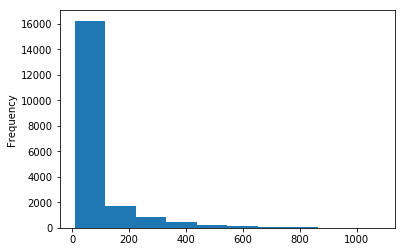

In [16]:
energy2['Appliances'].plot(kind='hist')

In [17]:
energy2['Appliances_log'] = np.log(energy2['Appliances'])

In [18]:
energy2['Appliances_log'].describe()

count    19735.000000
mean         4.303707
std          0.656307
min          2.302585
25%          3.912023
50%          4.094345
75%          4.605170
max          6.984716
Name: Appliances_log, dtype: float64

In [19]:
energy2['Appliances_log'].skew(), energy2['Appliances_log'].kurtosis()

(1.165816888806544, 1.5511049062820326)

Text(0.5, 1.0, 'Appliances Consumption')

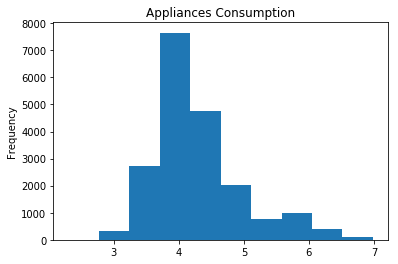

In [20]:
energy2['Appliances_log'].plot(kind='hist')
plt.title('Appliances Consumption')

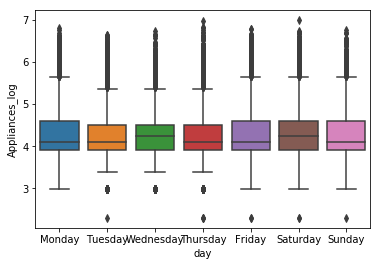

In [21]:
# Check with cons the outliers
# Examine consumption per day in week
ax1 = sns.boxplot(x="day", y="Appliances_log", data=energy2)

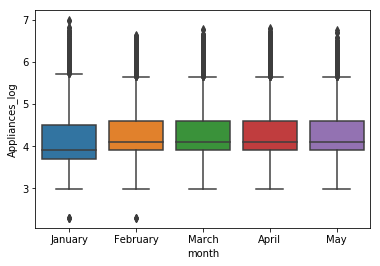

In [22]:
ax2 = sns.boxplot(x="month", y="Appliances_log", data=energy2)

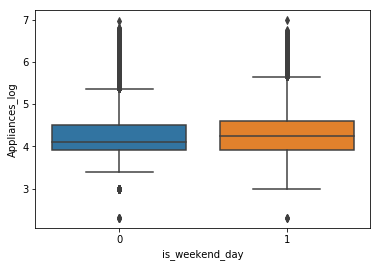

In [23]:
ax3 = sns.boxplot(x="is_weekend_day", y="Appliances_log", data=energy2)

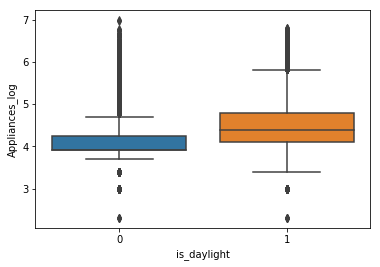

In [24]:
ax4 = sns.boxplot(x="is_daylight", y="Appliances_log", data=energy2)

In [25]:
energy2.groupby(['is_weekend_day']).mean()['Appliances_log']

is_weekend_day
0    4.286370
1    4.348897
Name: Appliances_log, dtype: float64

### From the correlation plot below there is a positive correlation (in general) between the temperatures from different rooms of the house and also with the external temperature

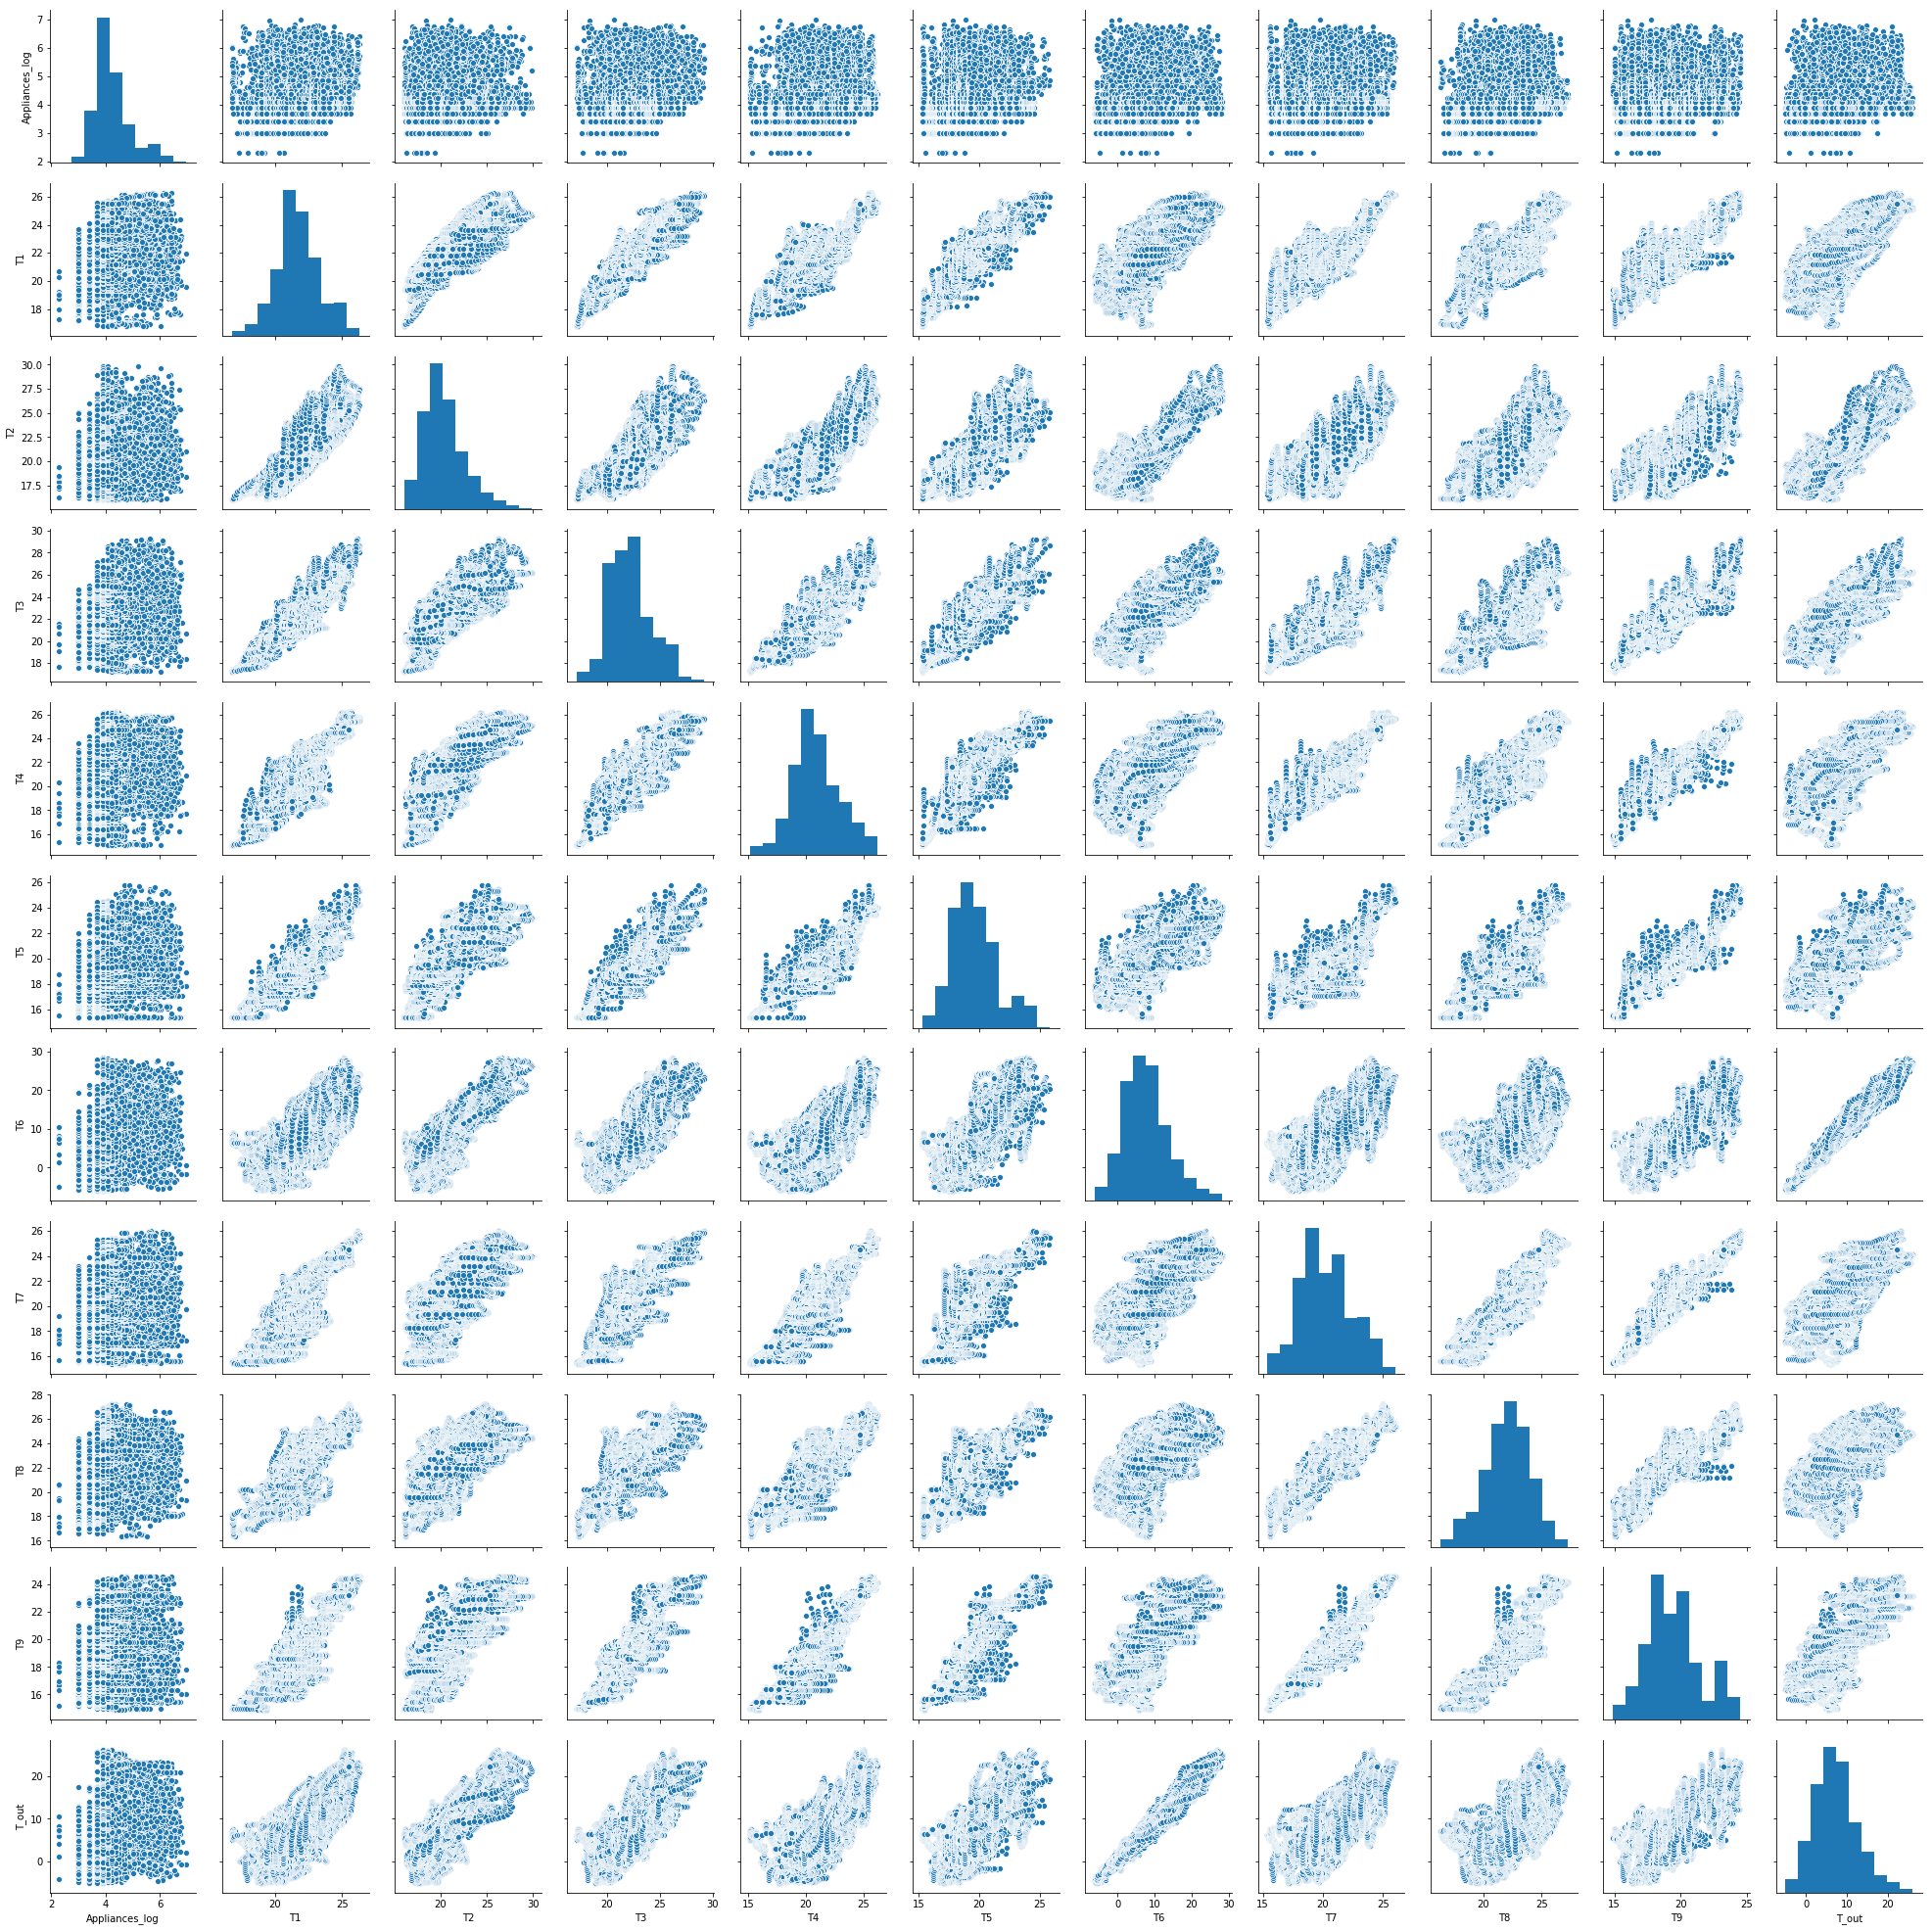

In [26]:
# Create correlation plot about the temperature in every room
temperature = energy2[['Appliances_log','T1', 'T2', 'T3','T4', 'T5', 'T6',  'T7', 'T8',  'T9', 'T_out']]
sns.pairplot(temperature)

In [27]:
# We examine Pearson correlation for variables of temperature.
corrs = temperature.corr(method='pearson').round(2)
print(corrs)

                Appliances_log    T1    T2    T3    T4    T5    T6    T7  \
Appliances_log            1.00  0.16  0.21  0.17  0.13  0.11  0.20  0.11   
T1                        0.16  1.00  0.84  0.89  0.88  0.89  0.65  0.84   
T2                        0.21  0.84  1.00  0.74  0.76  0.72  0.80  0.66   
T3                        0.17  0.89  0.74  1.00  0.85  0.89  0.69  0.85   
T4                        0.13  0.88  0.76  0.85  1.00  0.87  0.65  0.88   
T5                        0.11  0.89  0.72  0.89  0.87  1.00  0.63  0.87   
T6                        0.20  0.65  0.80  0.69  0.65  0.63  1.00  0.62   
T7                        0.11  0.84  0.66  0.85  0.88  0.87  0.62  1.00   
T8                        0.15  0.83  0.58  0.80  0.80  0.82  0.48  0.88   
T9                        0.09  0.84  0.68  0.90  0.89  0.91  0.67  0.94   
T_out                     0.18  0.68  0.79  0.70  0.66  0.65  0.97  0.63   

                  T8    T9  T_out  
Appliances_log  0.15  0.09   0.18  
T1             

In [28]:
col_names = corrs.columns.values

for col, row in ((corrs >= 0.8)  & (corrs != 1)).iteritems():
    print(col, col_names[row.values])

Appliances_log []
T1 ['T2' 'T3' 'T4' 'T5' 'T7' 'T8' 'T9']
T2 ['T1' 'T6']
T3 ['T1' 'T4' 'T5' 'T7' 'T8' 'T9']
T4 ['T1' 'T3' 'T5' 'T7' 'T8' 'T9']
T5 ['T1' 'T3' 'T4' 'T7' 'T8' 'T9']
T6 ['T2' 'T_out']
T7 ['T1' 'T3' 'T4' 'T5' 'T8' 'T9']
T8 ['T1' 'T3' 'T4' 'T5' 'T7' 'T9']
T9 ['T1' 'T3' 'T4' 'T5' 'T7' 'T8']
T_out ['T6']


### We conclude that T6 which is is temperature outside the building has very high correlation with the temperature of the weather station (at the airport) and less correlation with all the other temperatures.

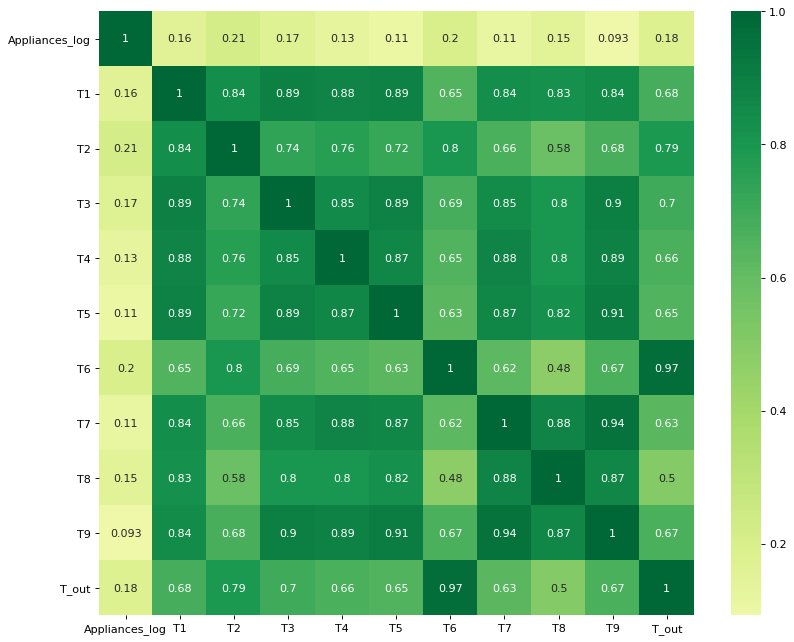

In [29]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(temperature.corr(method='pearson'), xticklabels=temperature.corr(method='pearson').columns, cmap='RdYlGn', center=0, annot=True)

### For humidity the results are not the same. Some features do not have linear relationship.

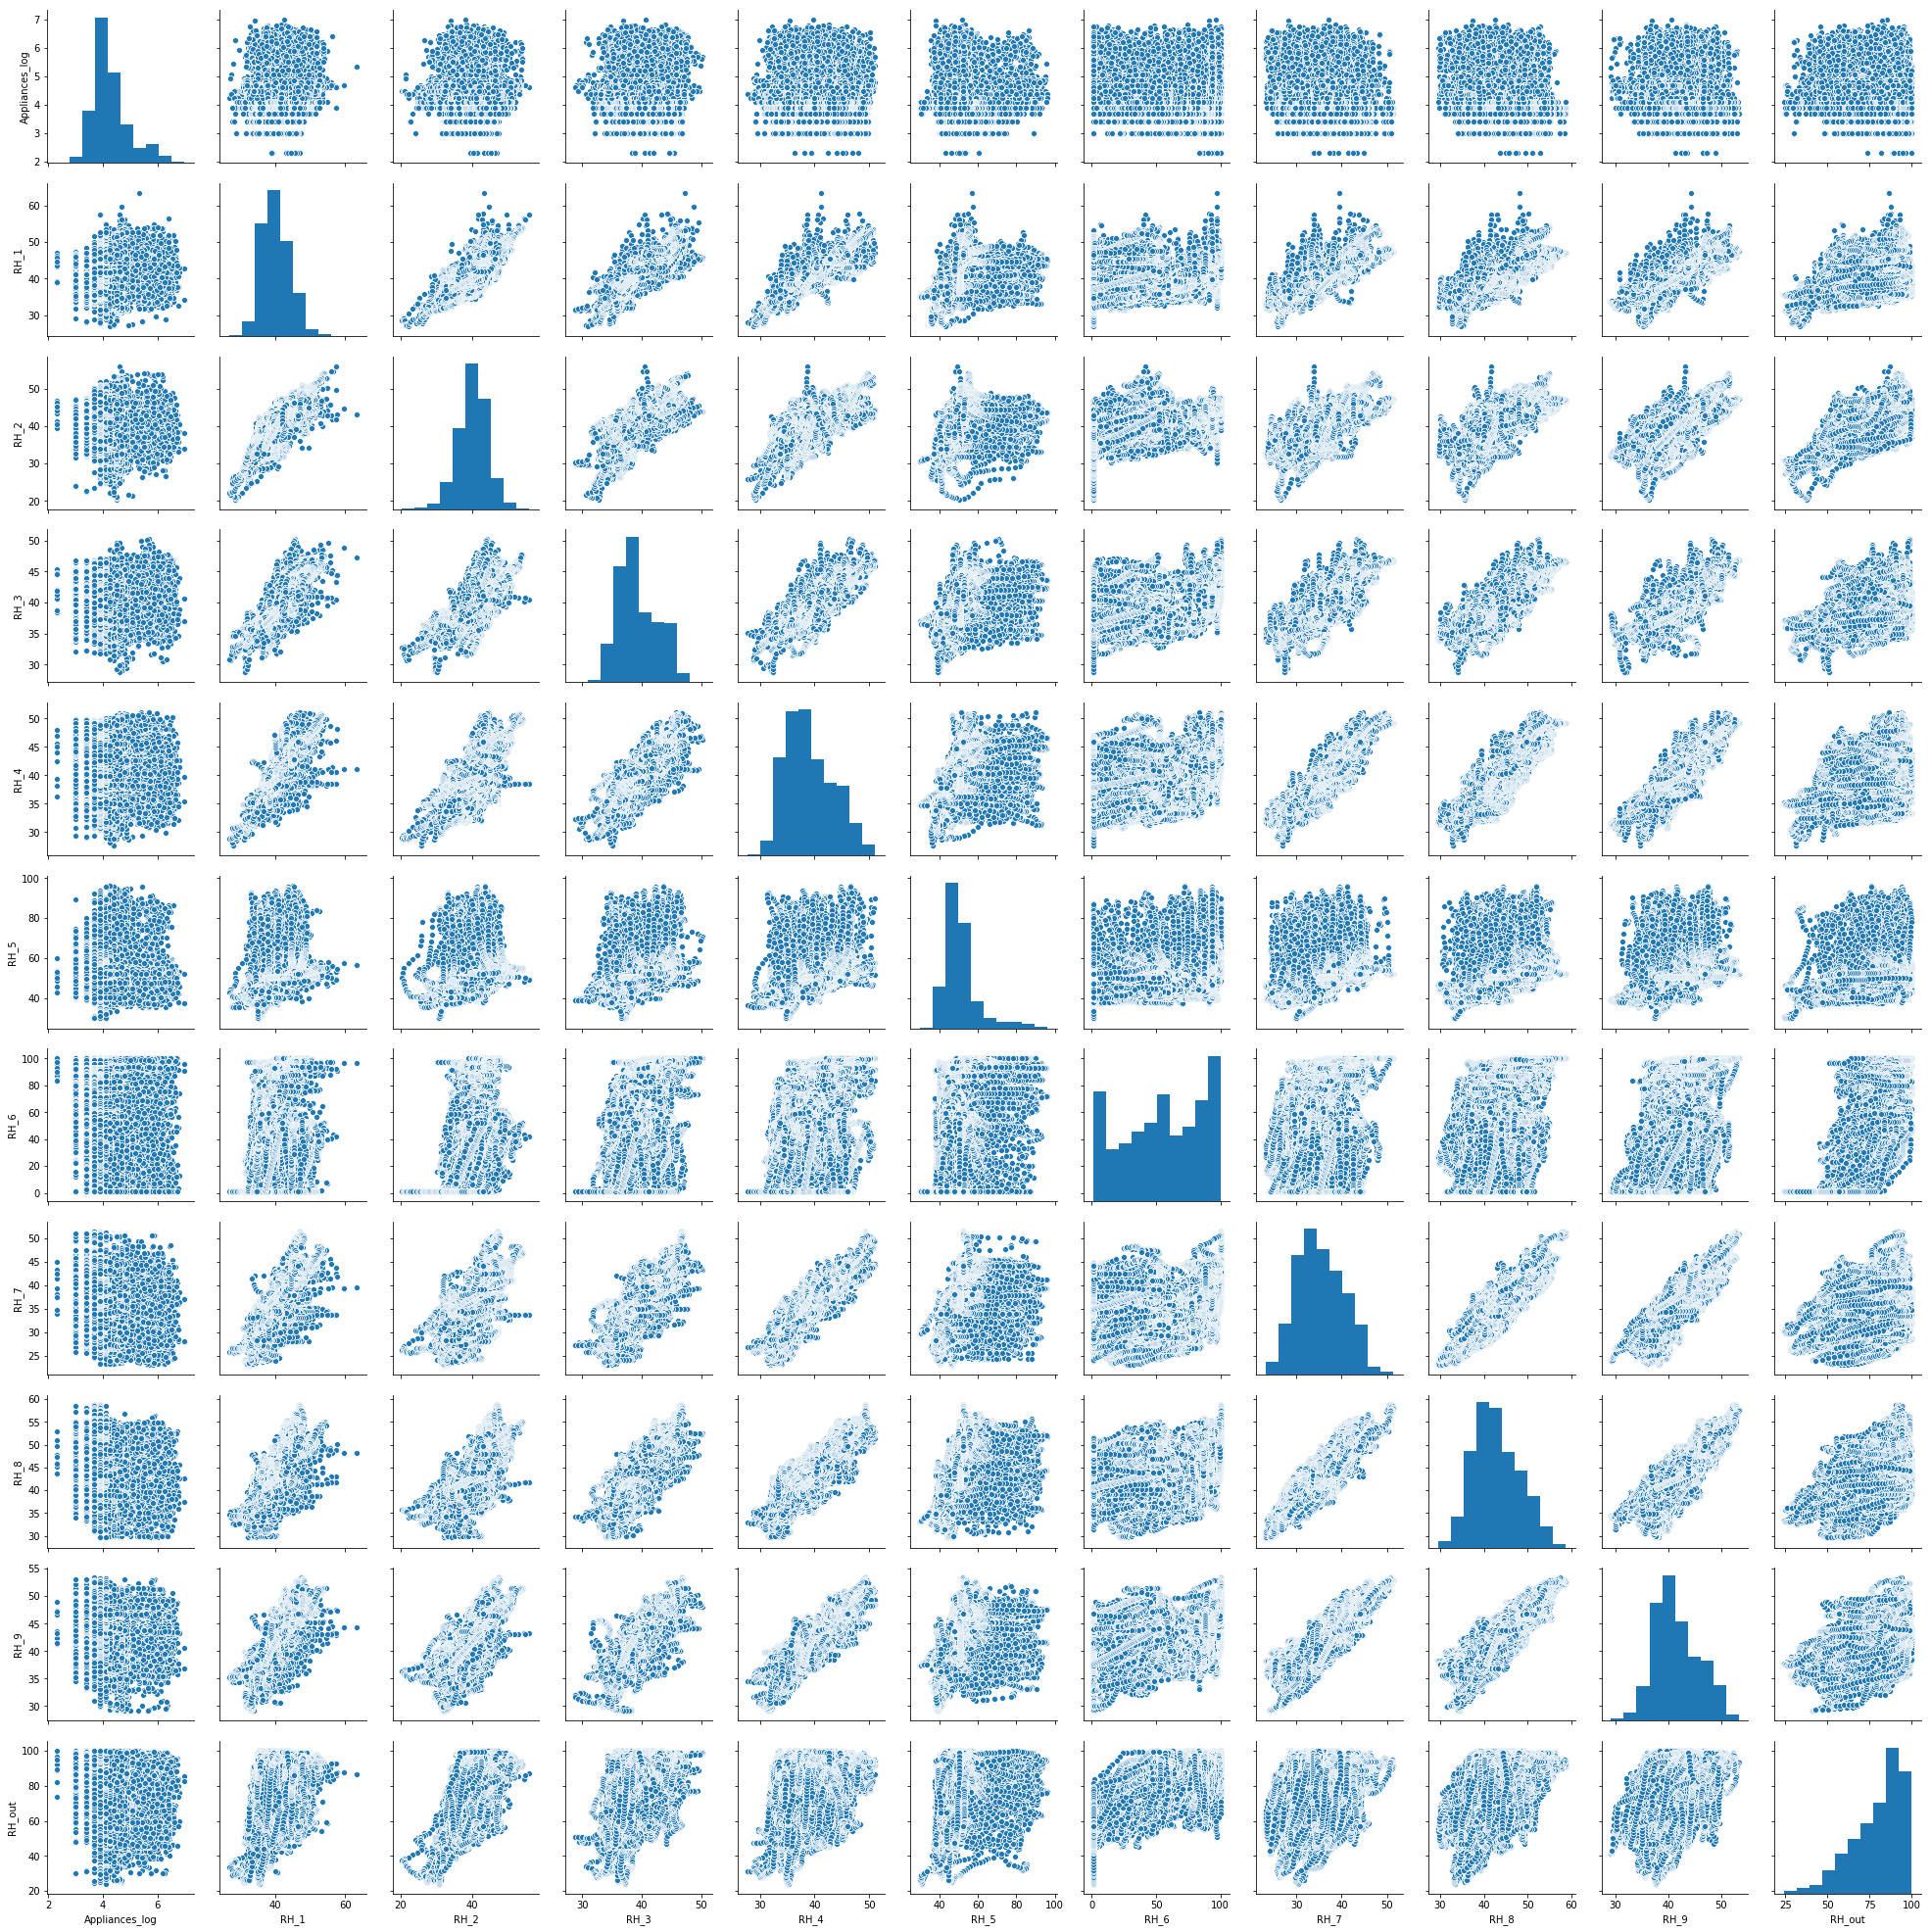

In [30]:
# Also, a pairplot for humidity.
humidity = energy2[['Appliances_log','RH_1', 'RH_2', 'RH_3',  'RH_4',  'RH_5',  'RH_6','RH_7', 'RH_8', 'RH_9',  'RH_out']]
sns.pairplot(humidity)

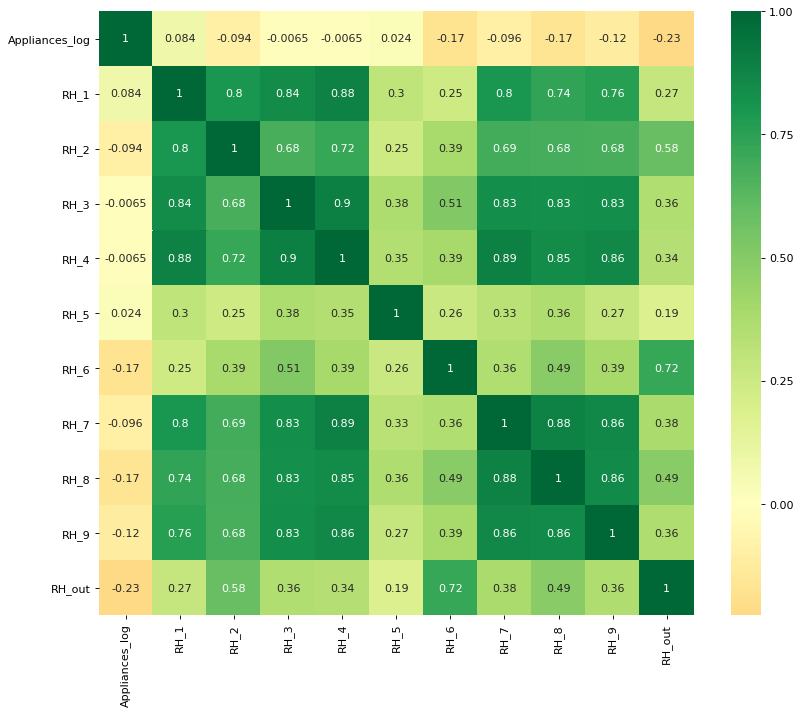

In [31]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(humidity.corr(method='pearson'), xticklabels=humidity.corr(method='pearson').columns, cmap='RdYlGn', center=0, annot=True)

In [32]:
corrs2 = humidity.corr(method='pearson').round(2)
print(corrs2)

                Appliances_log  RH_1  RH_2  RH_3  RH_4  RH_5  RH_6  RH_7  \
Appliances_log            1.00  0.08 -0.09 -0.01 -0.01  0.02 -0.17 -0.10   
RH_1                      0.08  1.00  0.80  0.84  0.88  0.30  0.25  0.80   
RH_2                     -0.09  0.80  1.00  0.68  0.72  0.25  0.39  0.69   
RH_3                     -0.01  0.84  0.68  1.00  0.90  0.38  0.51  0.83   
RH_4                     -0.01  0.88  0.72  0.90  1.00  0.35  0.39  0.89   
RH_5                      0.02  0.30  0.25  0.38  0.35  1.00  0.26  0.33   
RH_6                     -0.17  0.25  0.39  0.51  0.39  0.26  1.00  0.36   
RH_7                     -0.10  0.80  0.69  0.83  0.89  0.33  0.36  1.00   
RH_8                     -0.17  0.74  0.68  0.83  0.85  0.36  0.49  0.88   
RH_9                     -0.12  0.76  0.68  0.83  0.86  0.27  0.39  0.86   
RH_out                   -0.23  0.27  0.58  0.36  0.34  0.19  0.72  0.38   

                RH_8  RH_9  RH_out  
Appliances_log -0.17 -0.12   -0.23  
RH_1         

In [33]:
# Find the couple with correlation above 0.8
col_names2 = corrs2.columns.values

for col, row in ((corrs2 >= 0.8) & (corrs2 != 1)).iteritems():
    print(col, col_names2[row.values])

Appliances_log []
RH_1 ['RH_2' 'RH_3' 'RH_4' 'RH_7']
RH_2 ['RH_1']
RH_3 ['RH_1' 'RH_4' 'RH_7' 'RH_8' 'RH_9']
RH_4 ['RH_1' 'RH_3' 'RH_7' 'RH_8' 'RH_9']
RH_5 []
RH_6 []
RH_7 ['RH_1' 'RH_3' 'RH_4' 'RH_8' 'RH_9']
RH_8 ['RH_3' 'RH_4' 'RH_7' 'RH_9']
RH_9 ['RH_3' 'RH_4' 'RH_7' 'RH_8']
RH_out []


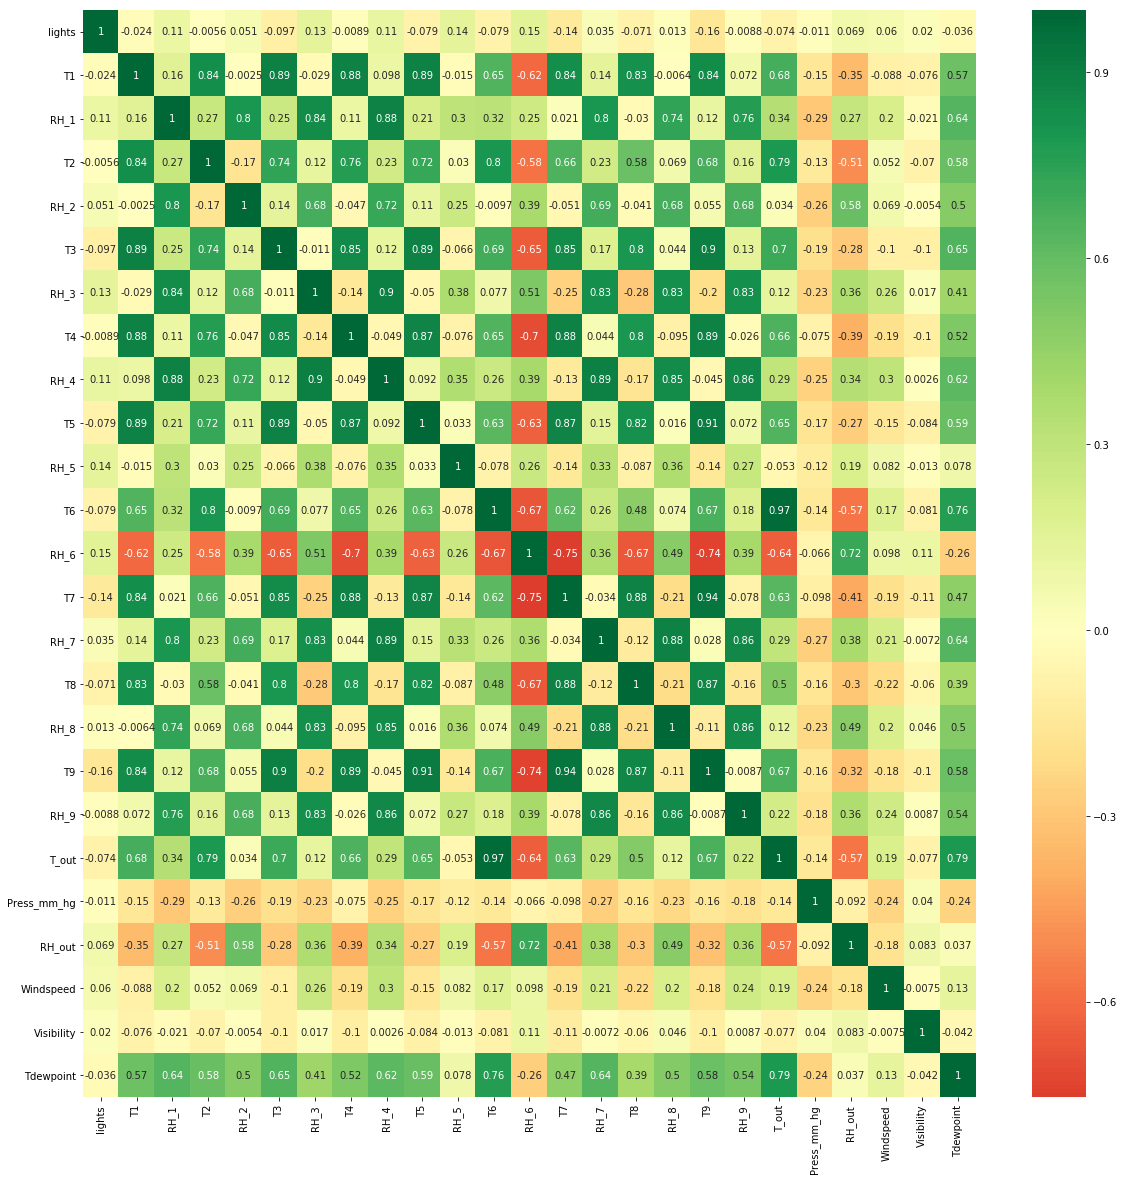

In [34]:
# All Heatmap
measurements = energy2[['lights', 'T1', 'RH_1', 'T2', 'RH_2',
       'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint']]
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(measurements.corr(method='pearson'), xticklabels=measurements.corr(method='pearson').columns, cmap='RdYlGn', center=0, annot=True,ax=ax)

## Descriptive statistics

In [35]:
temperature.describe()

Appliances_log            T1            T2            T3            T4  \
count    19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean         4.303707     21.686571     20.341219     22.267611     20.855335   
std          0.656307      1.606066      2.192974      2.006111      2.042884   
min          2.302585     16.790000     16.100000     17.200000     15.100000   
25%          3.912023     20.760000     18.790000     20.790000     19.530000   
50%          4.094345     21.600000     20.000000     22.100000     20.666667   
75%          4.605170     22.600000     21.500000     23.290000     22.100000   
max          6.984716     26.260000     29.856667     29.236000     26.200000   

                 T5            T6            T7            T8            T9  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      19.592106      7.910939     20.267106     22.029107     19.485828   
std        1.844623      6.090347      2.109993      1.956162      2.014712   
min       15.330000     -6.065000     15.390000     16.306667     14.890000   
25%       18.277500      3.626667     18.700000     20.790000     18.000000   
50%       19.390000      7.300000     20.033333     22.100000     19.390000   
75%       20.619643     11.256000     21.600000     23.390000     20.600000   
max       25.795000     28.290000     26.000000     27.230000     24.500000   

              T_out  
count  19735.000000  
mean       7.411665  
std        5.317409  
min       -5.000000  
25%        3.666667  
50%        6.916667  
75%       10.408333  
max       26.100000

In [36]:
temperature.skew()

Appliances_log    1.165817
T1                0.120917
T2                0.889658
T3                0.450777
T4                0.170384
T5                0.558220
T6                0.597471
T7                0.254722
T8               -0.256151
T9                0.382711
T_out             0.534273
dtype: float64

In [37]:
temperature.kurtosis()

Appliances_log    1.551105
T1                0.161601
T2                0.933397
T3               -0.007055
T4               -0.037633
T5                0.112724
T6                0.425549
T7               -0.461165
T8               -0.158742
T9               -0.324625
T_out             0.364291
dtype: float64

In [38]:
energy2.columns

Index(['date', 'Appliances', 'Hour', 'lights', 'T1', 'RH_1', 'T2', 'RH_2',
       'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'sunrise',
       'sunset', 'day length', 'day length hours', 'day length minutes',
       'month', 'is_weekend_day', 'is_daylight', 'Appliances_log'],
      dtype='object')

## Conclusions 
1. Most of temperatures are highly correlated. The outside temperatures (building & airport) are also highly correlated.
2. Log transofrmation at 'humidity' doesn't seem to improve linearity significantly.
3. Also the distribution of external humidity (from the Airport) has negative skewness. This same result is also for the 'RH6' (humidity outside the building). So, the humidity takes values above the mean with highest probability. 

## Examine Consumption:
## Appliances and Lights


In [39]:
cons_per_month = energy2.groupby(['month'])[['Appliances','lights']].sum()
cons_per_month

Appliances  lights
month                       
January       283510   13800
February      421550   26490
March         432800   17480
April         427200   10440
May           362950    6820

### Concerning that Lights have little weigth in the sum of consumption we take into consideration only the consumption of appliances

Text(0.5, 0, 'Month')

<Figure size 576x576 with 0 Axes>

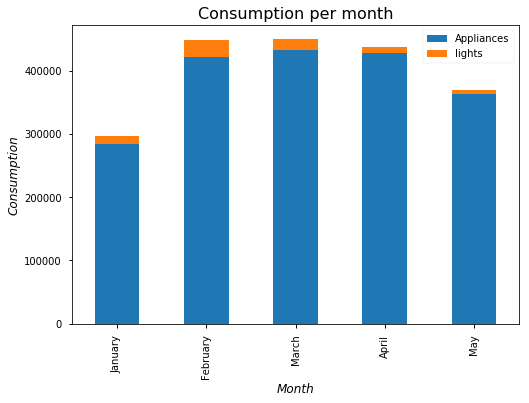

In [40]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn-notebook')
cons_per_month.plot(kind = 'bar', stacked = True)
plt.title('Consumption per month', fontsize = 16)
plt.ylabel('Consumption', fontsize=12, style='italic')
plt.xlabel('Month', fontsize=12, style='italic')

## Time series - Econometrics apporach
We are going to combat the problem of Energy Consumption as a time series problem. For this reason we implement some common time series methods like **ARIMA (or SARIMA)** from the statsmodels and **Seasonal Decomposition** with the help of **Prophet** library. Our aim is to both identify trends and make predictions.

In [41]:
import statsmodels.api as sm
import statsmodels

In [42]:
consumption = energy2[['Appliances','date']].set_index('date')

In [43]:
aggregate = consumption.resample('24h').sum()

(array([735985., 735995., 736016., 736024., 736045., 736055., 736076.,
        736085., 736106., 736116.]), <a list of 10 Text xticklabel objects>)

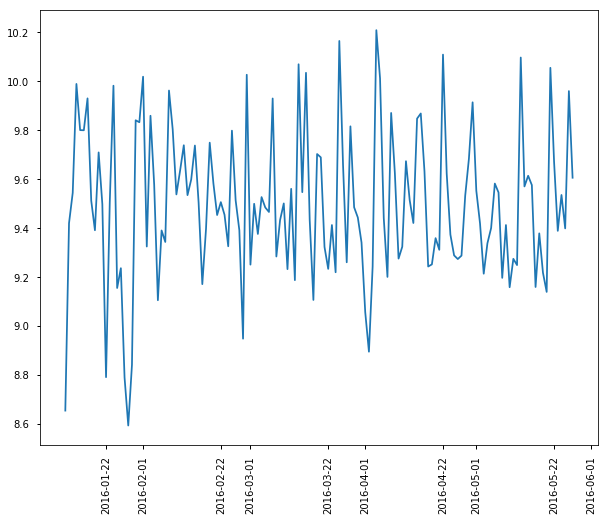

In [44]:
plt.figure(figsize=(10,8))
plt.plot(aggregate.index.values, np.log(aggregate['Appliances']))
plt.xticks(rotation='vertical')

### We will use the Augmented Dickey-Fuller test (default parameters) to test stationarity of the variable of consumption 
(https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)

In [45]:
sm.tsa.stattools.adfuller(consumption['Appliances'].values)

(-21.616378198036223,
 0.0,
 11,
 19723,
 {'1%': -3.430681600227742,
  '5%': -2.8616865555329394,
  '10%': -2.566848007525354},
 220573.74967981718)

From the above test we see that p-value is 0.0 (zero), so we reject the null hypothesis that the energy consumption is a non-stationary series. Also, the plot below ensures that the autocorrelation goes fast to zero. We can fit an ARMA model to predict future observations.

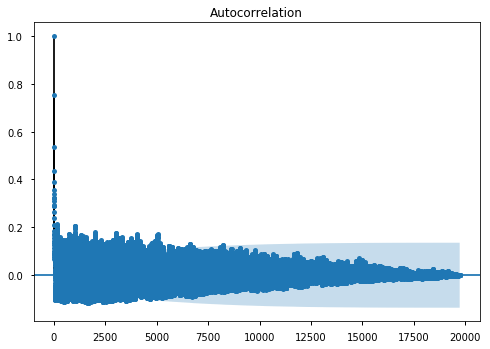

In [46]:
acf = statsmodels.graphics.tsaplots.plot_acf(consumption['Appliances'].values)

In [47]:
arma_5 = statsmodels.tsa.arima_model.ARMA(tuple(consumption['Appliances'][:19000].values), order=(5,0)).fit()

C:\Users\Maria\Anaconda3\envs\assignment-2\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Maria\Anaconda3\envs\assignment-2\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Maria\Anaconda3\envs\assignment-2\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

In [48]:
print(arma_5.params)

[ 9.72857913e+01  8.09277354e-01 -1.85383188e-01  1.01808359e-01
  1.76099889e-02  5.44430058e-02]


In [49]:
predict_cons = arma_5.predict(start = 19001, end=19734)

In [50]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt

In [51]:
mse = mean_squared_error(consumption['Appliances'][19000:].values, predict_cons)
rmse = sqrt(mse)
r2 = r2_score(consumption['Appliances'][19000:].values, predict_cons)
print('RMSE: %.3f' % rmse)
print('R-square: %.3f' % r2)

RMSE: 104.587
R-square: -0.011


# We are going to use Prophet api to identify trends in the data:
### Valuable help from:
1:https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/ 

2: https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a 

3: https://facebook.github.io/prophet/docs/quick_start.html#python-api

4: https://github.com/facebook/prophet

In [52]:
from fbprophet import Prophet

In [53]:
m = Prophet(changepoint_prior_scale=0.1,weekly_seasonality=True, daily_seasonality =True)
consumption['Appliances_orig'] = consumption['Appliances']  
# log-transform y
consumption['Appliances'] = np.log(consumption['Appliances'])
df = consumption.reset_index().rename(columns={'date':'ds', 'Appliances':'y'})
m.fit(df[0:19000])

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\Maria\Anaconda3\envs\assignment-2\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [54]:
future = m.make_future_dataframe(periods=735,freq = '10T')
forecast = m.predict(future)

In [55]:
forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0     2016-01-11 17:00:00  4.346581    3.997487    5.369795     4.346581   
1     2016-01-11 17:10:00  4.346621    4.030965    5.478906     4.346621   
2     2016-01-11 17:20:00  4.346662    4.085948    5.460702     4.346662   
3     2016-01-11 17:30:00  4.346703    4.136152    5.546416     4.346703   
4     2016-01-11 17:40:00  4.346743    4.170220    5.561148     4.346743   
5     2016-01-11 17:50:00  4.346784    4.184274    5.574397     4.346784   
6     2016-01-11 18:00:00  4.346824    4.170590    5.620871     4.346824   
7     2016-01-11 18:10:00  4.346865    4.204905    5.637739     4.346865   
8     2016-01-11 18:20:00  4.346906    4.276116    5.648644     4.346906   
9     2016-01-11 18:30:00  4.346946    4.260014    5.713326     4.346946   
10    2016-01-11 18:40:00  4.346987    4.257662    5.734453     4.346987   
11    2016-01-11 18:50:00  4.347028    4.314173    5.662090     4.347028   
12    2016-01-11 19:00:00  4.347068    4.251263    5.698122     4.347068   
13    2016-01-11 19:10:00  4.347109    4.280771    5.684381     4.347109   
14    2016-01-11 19:20:00  4.347150    4.294435    5.723535     4.347150   
15    2016-01-11 19:30:00  4.347190    4.294659    5.702027     4.347190   
16    2016-01-11 19:40:00  4.347231    4.197659    5.644701     4.347231   
17    2016-01-11 19:50:00  4.347271    4.193013    5.598287     4.347271   
18    2016-01-11 20:00:00  4.347312    4.217213    5.560988     4.347312   
19    2016-01-11 20:10:00  4.347353    4.179386    5.523601     4.347353   
20    2016-01-11 20:20:00  4.347393    4.060743    5.508389     4.347393   
21    2016-01-11 20:30:00  4.347434    4.048348    5.522186     4.347434   
22    2016-01-11 20:40:00  4.347475    4.028243    5.443253     4.347475   
23    2016-01-11 20:50:00  4.347515    3.933551    5.388053     4.347515   
24    2016-01-11 21:00:00  4.347556    3.876468    5.348933     4.347556   
25    2016-01-11 21:10:00  4.347597    3.820753    5.258587     4.347597   
26    2016-01-11 21:20:00  4.347637    3.830497    5.259481     4.347637   
27    2016-01-11 21:30:00  4.347678    3.767142    5.139503     4.347678   
28    2016-01-11 21:40:00  4.347718    3.697618    5.118293     4.347718   
29    2016-01-11 21:50:00  4.347759    3.622452    5.075728     4.347759   
...                   ...       ...         ...         ...          ...   
19705 2016-05-27 13:10:00  4.364627    3.878361    5.281492     4.289570   
19706 2016-05-27 13:20:00  4.364641    3.814271    5.231835     4.289250   
19707 2016-05-27 13:30:00  4.364655    3.842603    5.257451     4.288930   
19708 2016-05-27 13:40:00  4.364669    3.830397    5.191643     4.288609   
19709 2016-05-27 13:50:00  4.364683    3.804754    5.180985     4.288289   
19710 2016-05-27 14:00:00  4.364697    3.740725    5.263046     4.287969   
19711 2016-05-27 14:10:00  4.364711    3.808008    5.224613     4.287731   
19712 2016-05-27 14:20:00  4.364725    3.761508    5.152115     4.287608   
19713 2016-05-27 14:30:00  4.364739    3.737693    5.169250     4.287485   
19714 2016-05-27 14:40:00  4.364753    3.771387    5.220878     4.287363   
19715 2016-05-27 14:50:00  4.364767    3.718250    5.167176     4.287240   
19716 2016-05-27 15:00:00  4.364781    3.736190    5.158655     4.287117   
19717 2016-05-27 15:10:00  4.364795    3.751726    5.203494     4.287018   
19718 2016-05-27 15:20:00  4.364809    3.763421    5.154063     4.286924   
19719 2016-05-27 15:30:00  4.364823    3.773007    5.241750     4.286830   
19720 2016-05-27 15:40:00  4.364837    3.782864    5.266904     4.286735   
19721 2016-05-27 15:50:00  4.364851    3.867171    5.295345     4.286641   
19722 2016-05-27 16:00:00  4.364865    3.776963    5.277062     4.286367   
19723 2016-05-27 16:10:00  4.364879    3.847900    5.244271     4.285988   
19724 2016-05-27 16:20:00  4.364893    3.932362    5.347255     4.285609   
19725 2016-05-27 16:30:00  4.364907    3.868073    5.357130     4.28533

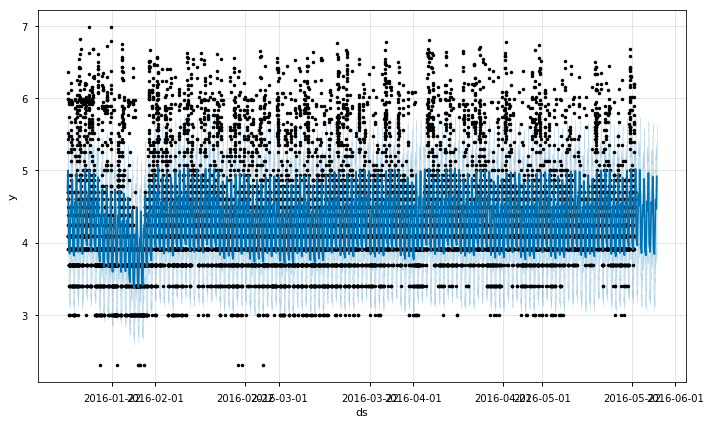

In [56]:
fig1 = m.plot(forecast)

### From the diagram below we can see the trends in the period from January to May, the weekly trends and the daily trends (yearly is out of scope)

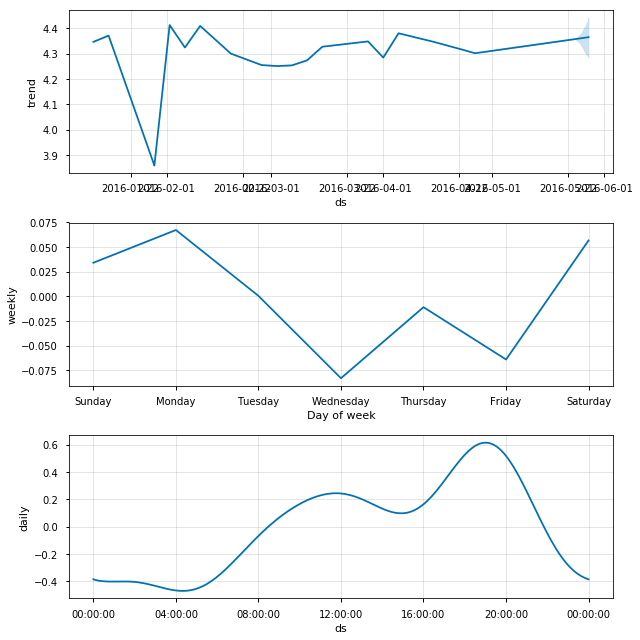

In [57]:
trends = m.plot_components(forecast)

In [58]:
sqrt(mean_squared_error(df['y'][19001:].values, forecast['yhat'][19001:].values))


0.5091823008895736

In [59]:
mean_absolute_error(df['y'][19001:].values, forecast['yhat'][19001:].values)

0.3409244751962119

In [60]:
r2_score(df['y'][19001:].values, forecast['yhat'][19001:].values)

0.2895047844987686

# Preprocess / Train/ Validation/ Test

### Preprocessing steps:
1. Create dummy variables
2. Scale Data

### Evaluation:

For the evaluation of our models we will use RMSE (Root Mean Square Error)

In [61]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_squared_log_error

## The observations of the dataset refer to a period that it smaller than one year, so it is possible to contain seasonality. This seasonality can be expressed with dummy variables, which explain the dependent variable (consumption)

In [62]:
#energy3 = energy2.set_index('date').resample('1h').mean()
energy3 = energy2.set_index('date')
energy3 = energy3.reset_index()
energy3.columns

Index(['date', 'Appliances', 'Hour', 'lights', 'T1', 'RH_1', 'T2', 'RH_2',
       'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'sunrise',
       'sunset', 'day length', 'day length hours', 'day length minutes',
       'month', 'is_weekend_day', 'is_daylight', 'Appliances_log'],
      dtype='object')

In [63]:
energy3['is_high_consumption_weekly'] = ((energy3['date'].dt.weekday == 0))

energy3['is_high_consumption_daily'] = ((energy3['date'].dt.time >= datetime.strptime('16:00:00', '%H:%M:%S').time()) & (energy3['date'].dt.time <= datetime.strptime('22:00:00','%H:%M:%S').time()))

In [64]:
energy3['is_high_consumption_weekly'] = energy3['is_high_consumption_weekly'].astype(int)
energy3['is_high_consumption_daily'] = energy3['is_high_consumption_daily'].astype(int)

### We are going to apply the below formula called "Heat Index", so as to combine Temperature and Humidity to one variable.
#### The heat index used by the National Weather Service (NWS) in the United States is based on many assumptions such as body mass, height, clothing, individual physical activity, blood thickness, and wind speed. As such, depending how significantly these assumptions vary from the reality of an individual, heat index estimates may not accurately reflect perceived temperature. The equation used by the NWS to estimate heat index was developed by George Winterling in 1978, and is meant to be valid for temperatures of 80°F or higher, and relative humidity of 40% or more
More information about the formula can be found here: https://en.wikipedia.org/wiki/Heat_index

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2d76f23cf1aa1270276dbfa88b58dd07c8fcabae)
 
where T is the temperature in Fahrenheit and R the humidity in percentage.

We are going to use below coefficients which serve a bigger range of temperatures and humidities.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d3344785f647edc045a70468b0bbeceda0658f02)

In [65]:
energy3.columns

Index(['date', 'Appliances', 'Hour', 'lights', 'T1', 'RH_1', 'T2', 'RH_2',
       'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'day', 'sunrise',
       'sunset', 'day length', 'day length hours', 'day length minutes',
       'month', 'is_weekend_day', 'is_daylight', 'Appliances_log',
       'is_high_consumption_weekly', 'is_high_consumption_daily'],
      dtype='object')

In [66]:
c1 = 0.363445176
c2 = 0.988622465
c3 = 4.777114035
c4 = -0.114037667
c5 = -0.000850208
c6 = -0.020716198
c7 = 0.000687678
c8 = 0.000274954
c9=0

In [67]:
heat_index= c1 + c2*energy3['T1'] + c3*energy3['RH_1'] + c4*energy3['T1']*energy3['RH_1']+ c5*energy3['T1']**2 + c6*energy3['RH_1']**2 + c7*energy3['T1']**2*energy3['RH_1']+ c8*energy3['T1']*energy3['RH_1']**2

In [68]:
energy3.insert(loc = 37, column = 'HI_1', value=heat_index)

In [69]:
energy3.head()

date  Appliances                Hour  lights     T1  \
0 2016-01-11 17:00:00          60 1900-01-01 17:00:00      30  19.89   
1 2016-01-11 17:10:00          60 1900-01-01 17:10:00      30  19.89   
2 2016-01-11 17:20:00          50 1900-01-01 17:20:00      30  19.89   
3 2016-01-11 17:30:00          50 1900-01-01 17:30:00      40  19.89   
4 2016-01-11 17:40:00          60 1900-01-01 17:40:00      40  19.89   

        RH_1    T2       RH_2     T3       RH_3            ...              \
0  47.596667  19.2  44.790000  19.79  44.730000            ...               
1  46.693333  19.2  44.722500  19.79  44.790000            ...               
2  46.300000  19.2  44.626667  19.79  44.933333            ...               
3  46.066667  19.2  44.590000  19.79  45.000000            ...               
4  46.333333  19.2  44.530000  19.79  45.000000            ...               

   day length  day length hours  day length minutes    month        HI_1  \
0       08:18               8.3               498.0  January  117.513125   
1       08:18               8.3               498.0  January  116.299691   
2       08:18               8.3               498.0  January  115.763556   
3       08:18               8.3               498.0  January  115.443280   
4       08:18               8.3               498.0  January  115.809174   

   is_weekend_day  is_daylight  Appliances_log  is_high_consumption_weekly  \
0               0            1        4.094345                           1   
1               0            0        4.094345                           1   
2               0            0        3.912023                           1   
3               0            0        3.912023                           1   
4               0            0        4.094345                           1   

   is_high_consumption_daily  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1  

[5 rows x 43 columns]

In [70]:
energy3['is_weekend_day'] = energy3['is_weekend_day'].replace(0,-1)
energy3['is_daylight'] = energy3['is_daylight'].replace(0,-1)
energy3['is_high_consumption_weekly'] = energy3['is_high_consumption_weekly'].replace(0,-1)
energy3['is_high_consumption_daily'] = energy3['is_high_consumption_daily'].replace(0,-1)

In [71]:
# Test 05---done
features = energy3[['lights', 'RH_1', 'RH_2',
       'T3', 'RH_3', 'T4', 'T5', 'RH_5', 'RH_7',
       'T8', 'RH_8', 'RH_9', 'T_out','Press_mm_hg', 
       'Windspeed', 'Visibility', 'Tdewpoint', 'RH_out','HI_1']].astype('float64')
target = energy3['Appliances_log'].astype('float64')

In [72]:
features.head()

lights       RH_1       RH_2     T3       RH_3         T4         T5  \
0    30.0  47.596667  44.790000  19.79  44.730000  19.000000  17.166667   
1    30.0  46.693333  44.722500  19.79  44.790000  19.000000  17.166667   
2    30.0  46.300000  44.626667  19.79  44.933333  18.926667  17.166667   
3    40.0  46.066667  44.590000  19.79  45.000000  18.890000  17.166667   
4    40.0  46.333333  44.530000  19.79  45.000000  18.890000  17.200000   

    RH_5       RH_7    T8       RH_8   RH_9     T_out  Press_mm_hg  Windspeed  \
0  55.20  41.626667  18.2  48.900000  45.53  6.600000        733.5   7.000000   
1  55.20  41.560000  18.2  48.863333  45.56  6.483333        733.6   6.666667   
2  55.09  41.433333  18.2  48.730000  45.50  6.366667        733.7   6.333333   
3  55.09  41.290000  18.1  48.590000  45.40  6.250000        733.8   6.000000   
4  55.09  41.230000  18.1  48.590000  45.40  6.133333        733.9   5.666667   

   Visibility  Tdewpoint  RH_out        HI_1  
0   63.000000        5.3    92.0  117.513125  
1   59.166667        5.2    92.0  116.299691  
2   55.333333        5.1    92.0  115.763556  
3   51.500000        5.0    92.0  115.443280  
4   47.666667        4.9    92.0  115.809174

## We use random split and k-fold cross validation. We consider that time series split do not add value to our scope. 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.35)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((12827, 19), (6908, 19), (12827,), (6908,))

In [74]:
features.columns

Index(['lights', 'RH_1', 'RH_2', 'T3', 'RH_3', 'T4', 'T5', 'RH_5', 'RH_7',
       'T8', 'RH_8', 'RH_9', 'T_out', 'Press_mm_hg', 'Windspeed', 'Visibility',
       'Tdewpoint', 'RH_out', 'HI_1'],
      dtype='object')

#### We use Standard Scaler for standarization (important step especially for Linear Regression)

In [75]:
scaler =  StandardScaler()
# Standardize only continuous features
X_train_scaled = scaler.fit_transform(X_train.iloc[:,0:19])
X_test_scaled = scaler.fit_transform(X_test.iloc[:,0:19])

### We run a Multiple Linear regression, fit the model and evaluate score.

In [76]:
lin_model = LinearRegression(normalize=False, n_jobs=-1)
lin_model.fit(X_train_scaled, y_train)

cv1 = cross_val_score(lin_model, X_train_scaled, y_train, cv=5, scoring='r2')
print('\n')
print("The R-square is:",round(cv1.mean(),3))
print('\n')
#cv2 = -cross_val_score(lin_model, X_train_scaled, y_train, cv=tscv, scoring='neg_mean_squared_error')
cv2 = -cross_val_score(lin_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
reg_metric = round(math.sqrt(cv2.mean()),3)
print("The root mean square error is:", reg_metric)
print('\n')



The R-square is: 0.251


The root mean square error is: 0.567




## We use 3 models to train our algorithms. We need to optimize hyperparameters with GridSearchCV. For that reason we split the initial dataset to train, validation and test set.
### We tune hyperparameters at validation set. We make a first evaluation and compare the score (RMSE) between the models.

![](https://cdn-images-1.medium.com/max/1600/1*Nv2NNALuokZEcV6hYEHdGA.png)

In [77]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.20)
XX_train.shape, XX_test.shape, yy_train.shape, yy_test.shape

((10261, 19), (2566, 19), (10261,), (2566,))

### a. SVR (use train subset)

In [78]:
svr_model = SVR()
pipe_svr = Pipeline([('standardizer', scaler), ('regressor', svr_model)])
param_grid_svr ={    'regressor__gamma' : [0.001, 0.01, 0.1],
                     'regressor__C' : [50,60,70] 
                }
#grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=tscv, error_score='raise')
grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, error_score='raise')
grid_svr.fit(XX_train,yy_train)
preds_svr = grid_svr.predict(XX_test)
#print(r2_score(yy_test, preds_svr))

In [79]:
print(grid_svr.best_estimator_,'\n')
val_svr_metric = math.sqrt(mean_squared_error(yy_test, preds_svr))
print('The root mean square error for SVR model is:',round(val_svr_metric,3))

Pipeline(memory=None,
     steps=[('standardizer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', SVR(C=50, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]) 

The root mean square error for SVR model is: 0.436


### b. Random Forest (use train subset)

In [80]:
# Random Forest (use train subset)
rf_model = RandomForestRegressor(random_state = 0, n_jobs=-1)
param_grid_rf = {'n_estimators': [100, 110, 130, 140]}
                 #'regressor__max_depth': [3, None],
                 #'regressor__max_features': [1, 3, 10],
                 #'regressor__min_samples_split': [2, 3, 10],
                 #'regressor__min_samples_leaf': [1, 3, 10],
                  #'regressor__bootstrap': [True, False]'''
                

grid_rf = GridSearchCV(estimator = rf_model, param_grid  = param_grid_rf,  cv=5, error_score='raise')

grid_rf.fit(XX_train, yy_train)
preds_rf = grid_rf.predict(XX_test)

In [81]:
print(grid_rf.best_estimator_)
print('\n')
val_rf_metric = math.sqrt(mean_squared_error(yy_test,preds_rf))
print('The root mean square error for Random Forest model is:',round(val_rf_metric,3))
print("The R-square score is:",round(r2_score(yy_test,preds_rf),3)*100,"%")

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


The root mean square error for Random Forest model is: 0.413
The R-square score is: 61.4 %


### c. XGBoost (use train subset)

In [82]:
xgb_model = xgb.XGBRegressor(n_jobs = -1)
param_grid_xgb = { 'max_depth':[4,5,6],
                  'n_estimators': [100, 110, 130, 140],
                   'learning_rate': [0.1, 0.5, 0.7]
                    }
grid_xgb = GridSearchCV(estimator = xgb_model, param_grid  = param_grid_xgb,  cv=5, error_score='raise')

grid_xgb.fit(XX_train, yy_train)
preds_xgb = grid_xgb.predict(XX_test)

In [83]:
print(grid_xgb.best_estimator_)
print('\n')
val_xgb_metric = math.sqrt(mean_squared_error(yy_test,preds_xgb))
print('The root mean square error for XGBoost model is:',round(val_xgb_metric,3))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


The root mean square error for XGBoost model is: 0.448


## Results

In [84]:
models = ['Multiple Linear Regression', 'SVR', 'Random Forest', 'XGBoost']
val_scores = [reg_metric, val_svr_metric, val_rf_metric, val_xgb_metric] 
all_models = dict(zip(models, val_scores))
pd.DataFrame.from_dict(all_models,orient='index').rename(columns= {0:'Metric-RMSE'})

Metric-RMSE
Multiple Linear Regression     0.567000
SVR                            0.435929
Random Forest                  0.412523
XGBoost                        0.447951

## We choose Random Forest to train our dataset. 
### We train on the whole train set (Train subset + Validation set)

In [85]:
opt_rf_model = RandomForestRegressor(random_state = 0, n_estimators=130)
opt_rf_model.fit(X_train_scaled,y_train)
opt_preds_rf = opt_rf_model.predict(X_test_scaled)

In [86]:
rmse = math.sqrt(mean_squared_error(y_test,opt_preds_rf))
#print(r2_score(y_test,opt_preds_rf))
print('The root mean square error for model is:',round(rmse,3))

The root mean square error for model is: 0.392


In [87]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [88]:
mean_absolute_percentage_error(y_test,opt_preds_rf)

5.958513945108539

Examine **Feature Importances** from random forest

In [89]:
opt_rf_model.feature_importances_

array([0.07654969, 0.05353726, 0.04860337, 0.06081501, 0.05370058,
       0.04005108, 0.0449433 , 0.05274678, 0.04107101, 0.0715934 ,
       0.07021505, 0.04341702, 0.03917795, 0.05933975, 0.03359433,
       0.02643933, 0.03681204, 0.09318502, 0.05420802])

Text(0.5, 1.0, 'Feature importances')

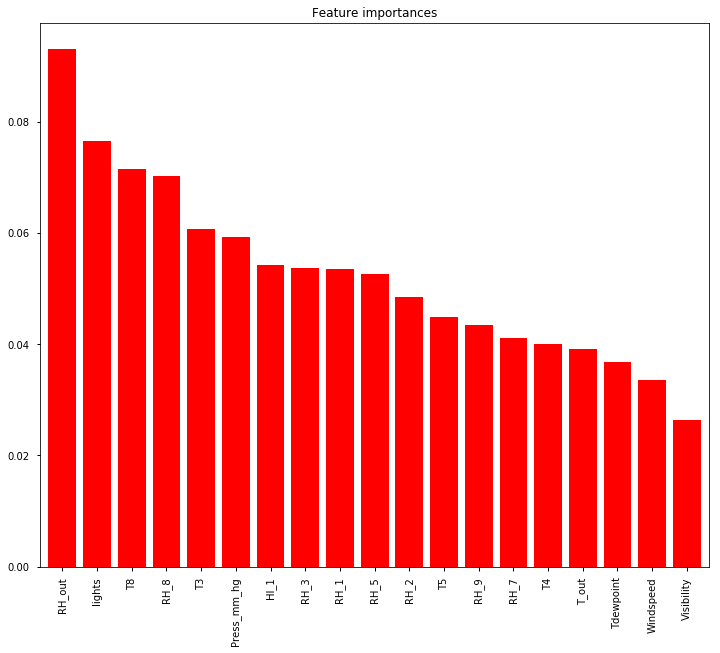

In [90]:
ranks = opt_rf_model.feature_importances_.tolist()
feats = features.columns.tolist()
pd.DataFrame(ranks, feats).sort_values(ascending=False,by=0).plot(kind='bar',color="r",align="center",figsize=(12, 10),width =0.8,legend =False)
plt.title('Feature importances')